In [132]:
pip install ipython-autotime

time: 5.2 s (started: 2022-10-17 13:34:34 -03:00)


In [133]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns (started: 2022-10-17 13:34:39 -03:00)


In [134]:
pip install google-cloud-vision

Note: you may need to restart the kernel to use updated packages.
time: 5.2 s (started: 2022-10-17 13:34:39 -03:00)


In [135]:
pip install opencv-python

time: 5.09 s (started: 2022-10-17 13:34:44 -03:00)


In [136]:
pip install google-cloud-automl

Note: you may need to restart the kernel to use updated packages.
time: 5.22 s (started: 2022-10-17 13:34:49 -03:00)


In [137]:
# Librerias
import pandas as pd
import numpy as np
import os
from google.cloud import vision
import io
import cv2
import urllib
from google.cloud import automl
import math
import urllib.request

time: 0 ns (started: 2022-10-17 13:34:54 -03:00)


In [138]:
# Aplicar vision api solo a una imagen
def vision_api(url, jason_path, t_product = 0.5, t_face = 0.5):
    # Credenciales
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = jason_path
    # Instanciar cliente
    client = vision.ImageAnnotatorClient()
    
    # Vector de salida (fila) prob. producto, producto, prob. sin rostro cliente, sin rostro cliente, contexto
    tamaño = (1,5)
    result = np.zeros(tamaño)
    
    # Se lee imagen
    image = vision.Image()
    image.source.image_uri = url
    
    # Obtener área total de la imagen
    url_open = urllib.request.urlopen(url)
    image_cv = np.asarray(bytearray(url_open.read()), dtype="uint8")
    image_cv = cv2.imdecode(image_cv, cv2.IMREAD_COLOR)
    area_total = image_cv.shape[0]*image_cv.shape[1]
    
    # Detección de objetos
    objects_response = client.object_localization(image=image)
    ##print('error1:')
    ##print(objects_response.error)
    # Contador del while por si hay error de lectura
    i=0
    while objects_response.error.message == 'We can not access the URL currently. Please download the content and pass it in.' \
    and i <5:
        print('Fallo en lectura de URL. Intentando nuevamente.\n')
        objects_response = client.object_localization(image=image)
        i += 1
    
    ##print('error2:')
    ##print(objects_response.error)
    objects = objects_response.localized_object_annotations
    ##print(objects)
    # Ver si en objetos hay algun producto
    # Contador de productos
    contador = 0
    # Inicializar area de producto
    area_producto = 0
    # Inicializar lista de confianzas
    confidence_list = []
    for object_ in objects:
        if (object_.name == 'Luggage & bags') or (object_.name == 'Bagged packaged goods') \
            or (object_.name =='Packaged goods') or (object_.name =='Boxed packaged goods') \
            or (object_.name =='Bag') or (object_.name =='Shipping box'):
            # Guardar confianza de la detección
            confidence_list.append(object_.score)
            # Guardar coordenadas
            coordenadas = []
            for vertex in object_.bounding_poly.normalized_vertices:
                coordenadas.append((vertex.x, vertex.y))          
            # Punto inferior izquierdo del rectángulo
            x0 = (int(coordenadas[0][0]*image_cv.shape[1]), int(coordenadas[0][1]*image_cv.shape[0]))
            # Punto superior derecho del rectángulo
            x1 = (int(coordenadas[2][0]*image_cv.shape[1]), int(coordenadas[2][1]*image_cv.shape[0])) 
            # Sumar áreas de cada producto
            area_producto += abs((x0[0]-x1[0])*(x0[1]-x1[1]))
            contador+=1
     
    if contador != 0:
        # Rellenar con la confianza máxima la posición correspondiente en la fila
        result[0][0] += max(confidence_list)
        
        # Comparación con umbral
        if max(confidence_list) >= t_product:
            # Rellenar con 1 la posición correspondiente en la fila
            result[0][1] += 1       
         
        # Calcular contexto
        # Dividir por área total
        razon_areas = area_producto/area_total
        # Rellenar contexto en fila
        result[0][4] = razon_areas
    
    # Detección de caras
    response = client.face_detection(image=image)
    ##print('error1:')
    ##print(response.error)
    # Contador del while por si hay error de lectura
    while response.error.message == 'We can not access the URL currently. Please download the content and pass it in.'\
    and i < 5:
        print('Fallo en lectura de URL. Intentando nuevamente.\n')
        response = client.face_detection(image=image)
        i += 1
    ##print('error2:')
    ##print(response.error)
    faces = response.face_annotations
    #from pprint import pprint
    ##print(response.face_annotations)
    #pprint(dir(client.face_detection(image=image)))
    
    # Inicializar lista de confianzas
    confidence_list = []
    for face in faces:
        # Guardar confianza de la detección
        confidence_list.append(face.detection_confidence)
    
    if len(faces) != 0: # Si ocurrre esto es por que hay detección
        # Rellenar con 1 menos la confianza máxima (confianza de que no haya un rostro) 
        # la posición correspondiente en la fila
        result[0][2] += (1-max(confidence_list))
        
        # Comparación con umbral
        if (1-max(confidence_list)) > 1 - t_face:
            # Rellenar con 1 la posición correspondiente en la matriz
            result[0][3] += 1
    
    # Entonces no hay rostro de cliente 
    else:
        result[0][2] += 1
        result[0][3] += 1    
    
    # Se hace un dataframe
    result_data = pd.DataFrame(result, columns=['Prob. Producto', 'Producto', 'Prob. Sin rostro cliente', 'Sin rostro cliente',\
                                                'Contexto'])
    return result_data    

time: 0 ns (started: 2022-10-17 13:34:55 -03:00)


In [6]:
vision_api('https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fnmunoz%40atenas.cl%2F149048661923.png?alt=media&token=265bb962-37dd-4107-a521-268a2211cd94', "clave2\\tc-sc-bi-bigdata-corp-tsod-dev-739359c1cf2a.json")

error1:
code: 14
message: "We can not access the URL currently. Please download the content and pass it in."

Fallo en lectura de URL. Intentando nuevamente.

error2:

[mid: "/j/5qg9b8"
name: "Packaged goods"
score: 0.847762942314148
bounding_poly {
  normalized_vertices {
    x: 0.01057373359799385
    y: 0.005080696661025286
  }
  normalized_vertices {
    x: 0.9966344833374023
    y: 0.005080696661025286
  }
  normalized_vertices {
    x: 0.9966344833374023
    y: 0.583638072013855
  }
  normalized_vertices {
    x: 0.01057373359799385
    y: 0.583638072013855
  }
}
]
error1:

error2:

[]


,Prob. Producto,Producto,Prob. Sin rostro cliente,Sin rostro cliente,Contexto
0,0.847763,1.0,1.0,1.0,0.568047


In [5]:
# Importar excel
import pandas as pd

base = pd.read_excel('C:\\Users\\ext_fantmiraudal\\Desktop\\base.xlsx','base')

In [6]:
base

,id,Suborden,Imageurl,Producto,Verde,Naranja,Negro,Caja Falabella,Bolsa,Caja,...,Guia (Despacho/Retiro),Foto B/W,Suelo,Imagen truncada,Interiores de Movil,Carretera,Cielo,Fachada,ERROR URL,Columna1
0,1,2130787479,https://firebasestorage.googleapis.com/v0/b/tx...,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,NaN
1,2,2130905477,https://firebasestorage.googleapis.com/v0/b/tx...,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,NaN
2,3,2130994563,https://firebasestorage.googleapis.com/v0/b/tx...,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,NaN
3,4,2131009815,https://firebasestorage.googleapis.com/v0/b/tx...,1,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,NaN
4,5,2131027031,https://firebasestorage.googleapis.com/v0/b/tx...,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17134,17135,14904882205901,https://firebasestorage.googleapis.com/v0/b/tx...,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,SE APRECIA PRODUCTO Y DOMICILIO/CLIENTE
17135,17136,14904882881401,https://firebasestorage.googleapis.com/v0/b/tx...,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,NO VALIDO
17136,17137,14904885176701,https://firebasestorage.googleapis.com/v0/b/tx...,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,SE APRECIA PRODUCTO Y DOMICILIO/CLIENTE
17137,17138,14904888884801,https://firebasestorage.googleapis.com/v0/b/tx...,1,0,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,SE APRECIA PRODUCTO Y DOMICILIO/CLIENTE


In [7]:
base.iloc[0]

id                                                                                   1
Suborden                                                                    2130787479
Imageurl                             https://firebasestorage.googleapis.com/v0/b/tx...
Producto                                                                             1
Verde                                                                                0
Naranja                                                                              0
Negro                                                                                0
Caja Falabella                                                                       0
Bolsa                                                                                0
Caja                                                                                 1
Cantidad de Bultos                                                                   3
Etiqueta Envio                             

In [9]:
# Extraer labels (diccionario) para detección de imagen con vision api
def vision_api_labels_extraction(url, jason_path):
    # Columnas de interes
    identification = row['id']
    suborden = row['Suborden']
    url = row['Imageurl']
    producto = row['Producto']
    
    # Credenciales
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = jason_path
    # Instanciar cliente
    client = vision.ImageAnnotatorClient()
    
    # Inicializar diccionario
    result = {}
    
    # Se lee imagen
    image = vision.Image()
    image.source.image_uri = url
    
    errores = 0
    
    # Obtener dimensiones de imagen
    try:
        url_open = urllib.request.urlopen(url)
        image_cv = np.asarray(bytearray(url_open.read()), dtype="uint8")
        image_cv = cv2.imdecode(image_cv, cv2.IMREAD_COLOR)
        #Dimensiones imagen
        height = image_cv.shape[0]
        width = image_cv.shape[1]
        channels = image_cv.shape[2]
    #except urllib.error.HTTPError as error:
    except:
        height = 0
        width = 0
        channels = 0
        
        print('error')
        errores=1
    #url_open = urllib.request.urlopen(url)
    #image_cv = np.asarray(bytearray(url_open.read()), dtype="uint8")
    #image_cv = cv2.imdecode(image_cv, cv2.IMREAD_COLOR)
    #Dimensiones imagen
    #height = image_cv.shape[0]
    #width = image_cv.shape[1]
    #channels = image_cv.shape[2]
    
    # Rellenar diccionario
    result['id'] = identification
    result['Suborden'] = suborden
    result['image_id'] = str(identification) + '_' + str(suborden)
    result['Imageurl'] = url
    result['Producto'] = producto
    result['height'] = height
    result['width'] = width
    result['channels'] = channels

    # Ver si en objetos hay algun producto
    # Contador de productos
    contador = 0
    # Inicializar caja vacía
    boxes = np.empty((0,4))
    # Inicializa lista de áreas vacia
    area_list = []
    if producto == 1 and errores == 0:
        # Detección de objetos
        objects_response = client.object_localization(image=image)
        # Contador del while por si hay error de lectura
        #i=0
        #while objects_response.error.message == \
        #'We can not access the URL currently. Please download the content and pass it in.' \
        #and i<0:
            #print('Fallo en lectura de URL. Intentando nuevamente.\n')
        #    objects_response = client.object_localization(image=image)
        #    i += 1
        objects = objects_response.localized_object_annotations
        for object_ in objects:
            if (object_.name == 'Luggage & bags') or (object_.name == 'Bagged packaged goods') \
                or (object_.name =='Packaged goods') or (object_.name =='Boxed packaged goods') \
                or (object_.name =='Bag') or (object_.name =='Shipping box'):
                # Guardar coordenadas
                coordenadas = []
                for vertex in object_.bounding_poly.normalized_vertices:
                    coordenadas.append((vertex.x, vertex.y))          
                # Coordenadas
                x_min = int(coordenadas[0][0]*image_cv.shape[1])
                y_min = int(coordenadas[0][1]*image_cv.shape[0])
                x_max = int(coordenadas[2][0]*image_cv.shape[1])
                y_max = int(coordenadas[2][1]*image_cv.shape[0])
                # Obtención de caja
                new_boxes = np.array([[x_min,y_min,x_max,y_max]])
                boxes = np.concatenate((boxes, new_boxes))
                # Area de cada producto
                area_producto = abs((x_max-x_min)*(y_max-y_min))
                area_list.append(area_producto)
                contador+=1
        
        if contador != 0:
            area_array = np.array(area_list)
            result['boxes'] = boxes
            result['labels'] = np.ones(contador)
            result['area'] = area_array
            result['iscrowd'] = np.zeros(contador)
        else:
            result = {}
    
    elif errores == 1:
        result = {}
    
    else: 
        area_array = np.array(area_list)
        result['boxes'] = boxes
        result['labels'] = np.ones(contador)
        result['area'] = area_array
        result['iscrowd'] = np.zeros(contador)
    
    return result   

In [344]:
#test
jason_path="clave2\\tc-sc-bi-bigdata-corp-tsod-dev-739359c1cf2a.json"
row = base.iloc[4]
new_row = vision_api_labels_extraction(row, jason_path)

Fallo en lectura de URL. Intentando nuevamente.

[(0.24996203184127808, 0.32527926564216614), (0.6128681302070618, 0.32527926564216614), (0.6128681302070618, 0.7843033671379089), (0.24996203184127808, 0.7843033671379089)]
[(0.10597232729196548, 0.6653538346290588), (0.3044702112674713, 0.6653538346290588), (0.3044702112674713, 0.8470564484596252), (0.10597232729196548, 0.8470564484596252)]
[(5.173214594833553e-05, 0.6633701920509338), (0.12202941626310349, 0.6633701920509338), (0.12202941626310349, 0.753714382648468), (5.173214594833553e-05, 0.753714382648468)]


In [10]:
# generación de diccionario
jason_path="key\\tc-sc-bi-bigdata-corp-tsod-dev-82c15beedd2a.json"
dic = {}
i=0
n=0
for index in range(len(base)):
    row = base.iloc[index]
    new_row = vision_api_labels_extraction(row, jason_path)
    if new_row:
        # Nombre de diccionario
        name = new_row['image_id']
        # Diccionario de diccionarios
        dic[name] = new_row
        n+=1
    if i%500 == 499:
        print('numero de imágenes etiquetadas: ', str(n))
    i+=1

error
error
numero de imágenes etiquetadas:  272
error
error
error
error
error
error
numero de imágenes etiquetadas:  539
error
error
error
error
numero de imágenes etiquetadas:  784
error
error
error
error
error
error
error
error
error
numero de imágenes etiquetadas:  1016
error
error
error
error
numero de imágenes etiquetadas:  1301
error
numero de imágenes etiquetadas:  1557
error
error
error
numero de imágenes etiquetadas:  1853
error
numero de imágenes etiquetadas:  2117


ServiceUnavailable: 503 failed to connect to all addresses

In [20]:
dic

{'2_2130905477': {'id': 2,
  'Suborden': 2130905477,
  'image_id': '2_2130905477',
  'Imageurl': 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fmabahamondes%40pipau.cl%2F2130905477.png?alt=media&token=752bbeeb-541a-4192-8ea7-b6652af70f04',
  'Producto': 0,
  'height': 252,
  'width': 119,
  'channels': 3,
  'boxes': array([], shape=(0, 4), dtype=float64),
  'labels': array([], dtype=float64),
  'area': array([], dtype=float64),
  'iscrowd': array([], dtype=float64)},
 '3_2130994563': {'id': 3,
  'Suborden': 2130994563,
  'image_id': '3_2130994563',
  'Imageurl': 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fjclagos%40pipau.cl%2F2130994563.png?alt=media&token=f8cc78ad-d0d2-4a74-b023-2816d0735a2c',
  'Producto': 0,
  'height': 260,
  'width': 195,
  'channels': 3,
  'boxes': array([], shape=(0, 4), dtype=float64),
  'labels': array([], dtype=float64),
  'area': array([], dtype=float64),
 

In [21]:
dic[1]

KeyError: -1

In [15]:
p = 0
sp = 0
for i in dic:
    if dic[i]['Producto'] == 1:
        p+=1
    else:
        sp+=1      

In [16]:
print(p)
print(sp)

1736
504


In [17]:
# Guardar diccionario como json
import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

# create json object from dictionary
json = json.dumps(dic, cls=NpEncoder)

# open file for writing, "w" 
f = open("dict.json","w")

# write json object to file
f.write(json)

# close file
f.close()

In [22]:
# Guardar diccionario como txt
# open file for writing
f = open("dict.txt","w")

# write file
f.write( str(dic) )

# close file
f.close()

In [19]:
# Guardar diccionario como pickle
# load pickle module
import pickle

# create a binary pickle file 
f = open("dict.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(dic,f)

# close file
f.close()

In [310]:
# importing the module
import json
 
# Opening JSON file
with open('dict.json') as json_file:
    data = json.load(json_file)

In [311]:
data

{'1_2130787479': {'id': 1,
  'Suborden': 2130787479,
  'image_id': '1_2130787479',
  'Imageurl': 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fjajensen%40jensen.cl%2F2130787479.png?alt=media&token=c4c76fd7-de5d-48f1-9f61-362df1d6f6df',
  'Producto': 1,
  'height': 250,
  'width': 187,
  'channels': 3,
  'boxes': [[91.0, 187.0, 183.0, 26.0],
   [41.0, 169.0, 86.0, 74.0],
   [74.0, 167.0, 98.0, 80.0]],
  'labels': [1.0, 1.0, 1.0],
  'area': [14812, 4275, 2088],
  'iscrowd': [0.0, 0.0, 0.0]}}

In [89]:
# aplicar filtro de producto y de error_url a data base
new_base = base.copy()
filtro_producto = new_base[(new_base['Producto'] == 1) & (new_base['ERROR URL'] == 0)]
filtro_no_producto = new_base[(new_base['Producto'] == 0) & (new_base['ERROR URL'] == 0)]

In [90]:
filtro_producto

,Suborden,Imageurl,Producto,Verde,Naranja,Negro,Caja Falabella,Bolsa,Caja,Cantidad de Bultos,...,Guia (Despacho/Retiro),Foto B/W,Suelo,Imagen truncada,Interiores de Movil,Carretera,Cielo,Fachada,ERROR URL,Columna1
0,149046188492,https://firebasestorage.googleapis.com/v0/b/tx...,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
1,149046194567,https://firebasestorage.googleapis.com/v0/b/tx...,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
2,149046200287,https://firebasestorage.googleapis.com/v0/b/tx...,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
3,149046194290,https://firebasestorage.googleapis.com/v0/b/tx...,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
4,149046201605,https://firebasestorage.googleapis.com/v0/b/tx...,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17133,149048097529,https://firebasestorage.googleapis.com/v0/b/tx...,1,1,0,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,SE APRECIA PRODUCTO Y DOMICILIO/CLIENTE
17134,149048420584,https://firebasestorage.googleapis.com/v0/b/tx...,1,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,1,0,SE APRECIA PRODUCTO Y DOMICILIO/CLIENTE
17135,149048536367,https://firebasestorage.googleapis.com/v0/b/tx...,1,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,1,0,SE APRECIA PRODUCTO Y DOMICILIO/CLIENTE
17136,149048178115,https://firebasestorage.googleapis.com/v0/b/tx...,1,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,1,0,SE APRECIA PRODUCTO Y DOMICILIO/CLIENTE


In [91]:
filtro_no_producto

,Suborden,Imageurl,Producto,Verde,Naranja,Negro,Caja Falabella,Bolsa,Caja,Cantidad de Bultos,...,Guia (Despacho/Retiro),Foto B/W,Suelo,Imagen truncada,Interiores de Movil,Carretera,Cielo,Fachada,ERROR URL,Columna1
24,149046224768,https://firebasestorage.googleapis.com/v0/b/tx...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,NaN
32,149046240204,https://firebasestorage.googleapis.com/v0/b/tx...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
39,146002384692,https://firebasestorage.googleapis.com/v0/b/tx...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
54,149046188821,https://firebasestorage.googleapis.com/v0/b/tx...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
55,149046188820,https://firebasestorage.googleapis.com/v0/b/tx...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17081,149047609021,https://firebasestorage.googleapis.com/v0/b/tx...,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,NO VALIDO
17087,149048163161,https://firebasestorage.googleapis.com/v0/b/tx...,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,NO VALIDO
17117,149048421049,https://firebasestorage.googleapis.com/v0/b/tx...,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,NO VALIDO
17128,2131522079,https://firebasestorage.googleapis.com/v0/b/tx...,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,FOTO BOLETA


In [139]:
# Aplicar AutoMl solo a una imagen
def auto_ml(url, jason_path, threshold = 0.5):
    # Credenciales
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = jason_path
    
    # id del proyeto y del modelo para obtener la dirección donde esta alojado el modelo
    project_id = "tc-sc-bi-bigdata-corp-tsod-dev"
    # si se cambia el modelo, hay que tener cuidado con las etiquetas
    model_id = "ICN5209188124751560704"
    
    # Instanciar cliente
    prediction_client = automl.PredictionServiceClient()
    
    # Obtención dirección donde esta alojado el modelo
    model_full_id = automl.AutoMlClient.model_path(project_id, "us-central1", model_id)
    
    # Leer imagen del url
    url_open = urllib.request.urlopen(url)
    content = url_open.read()
    
    image = automl.Image(image_bytes=content)
    payload = automl.ExamplePayload(image=image)
    
    # Se escoge el valor del treshold
    params = {"score_threshold": str(threshold)}
    
    # Se aplica el modelo
    request = automl.PredictRequest(name=model_full_id, payload=payload, params=params)
    response = prediction_client.predict(request=request)
    
    # Vector de salida (fila) Prob. Etiqueta producto, Etiqueta producto, Prob. Numero domicilio, Numero domicilio
    tamaño = (1,4)
    result = np.zeros(tamaño)
    
    # Se verifica si el modelo identifica la etiqueta del producto y el numero de domicilio,
    # dependiendo de lo anterior se rellena con el 'score' y un 1 o 0 si hay o no detección 
    # respectivamente, segun el umbral escogido.
    for resultado in response.payload:
        if resultado.display_name == 'etiqueta_produto':
            result[0,0] = resultado.classification.score
            result[0,1] += 1
        if resultado.display_name == 'numero_domicilio':
            result[0,2] = resultado.classification.score
            result[0,3] += 1
    
    # Se hace un dataframe
    result_data = pd.DataFrame(result, columns=['Prob. Etiqueta producto', 'Etiqueta producto', 'Prob. Numero domicilio',\
                                                'Numero domicilio'])
    return result_data    

time: 0 ns (started: 2022-10-17 13:34:55 -03:00)


In [33]:
url = 'https://prdadessacorptrl.blob.core.windows.net/cl-images/20220519233512-Falabella-149053383533-1-EVIDENCE.png'
jason="key\\tc-sc-bi-bigdata-corp-tsod-dev-82c15beedd2a.json"
auto_ml(url, jason)

NameError: name 'auto_ml' is not defined

In [140]:
# Función para calcular score
def calculo_score(data_frame):
    array = np.array(data_frame)
    # Inicialización de los pesos
    w_product = 0.3
    w_without_face = 0.1
    w_context = 0.2
    w_product_label = 0.3
    w_address_number = 0.1
    # Función para mapear la importancia del contexto exp(-(x-0.5)^2*K)
    k = 55.3
    new_context = math.exp(-(data_frame['Contexto'][0]-0.5)**2*k)
    # Se hace un dataframe con los valores obtenidos
    score = data_frame['Producto'][0]*w_product + data_frame['Sin rostro cliente'][0]*w_without_face + \
    new_context*w_context + data_frame['Etiqueta producto'][0]*w_product_label + \
    data_frame['Numero domicilio'][0]*w_address_number
    
    return score

time: 15 ms (started: 2022-10-17 13:34:55 -03:00)


In [141]:
# Función que retorna las confidencias + el score en un dataframe
def full_model(url,jason_path_api, jason_path_automl):
    # Se aplica vision_api y auto_ml
    df_1 = vision_api(url, jason_path_api)
    df_2 = auto_ml(url, jason_path_automl)
    # Se contanenan resultados
    df_concatenado = pd.concat([df_1, df_2], axis=1)
    # Se calcula el score
    score = calculo_score(df_concatenado)
    # Se concatena todo lo anterior en un dataframe
    df_score = pd.DataFrame(np.array([score]), columns=['Score'])
    return pd.concat([df_concatenado, df_score], axis=1)

time: 16 ms (started: 2022-10-17 13:34:55 -03:00)


In [37]:
#url="https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fjavillalobos%40pipau.cl%2F149045394625.png?alt=media&token=335839a5-d0f5-4e5a-bff7-206fac166528"
#url = 'https://firebasestorage.googleapis.com/v0/b/txd-scex-tmgt-geosort-prod.appspot.com/o/delivery%2Fvirivera%40pipau.cl%2F149045744368.png?alt=media&token=6eb175fd-03a4-4338-aaa8-35d3d26cf7eb'
url = 'https://prdadessacorptrl.blob.core.windows.net/cl-images/20220613223751-Falabella-149060319936-1-EVIDENCE.png'
jason_path_api= "clave2\\tc-sc-bi-bigdata-corp-tsod-dev-739359c1cf2a.json"
jason_path_automl="key\\tc-sc-bi-bigdata-corp-tsod-dev-82c15beedd2a.json"
full_model(url,jason_path_api, jason_path_automl)

error1:

error2:

[]
error1:

error2:

[]
payload {
  annotation_spec_id: "6425997302246146048"
  classification {
    score: 0.9998859167098999
  }
  display_name: "none_of_the_above"
}



,Prob. Producto,Producto,Prob. Sin rostro cliente,Sin rostro cliente,Contexto,Prob. Etiqueta producto,Etiqueta producto,Prob. Numero domicilio,Numero domicilio,Score
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.1


In [71]:
data = pd.read_csv('C:\\Users\\ext_fantmiraudal\\Downloads\\new_data\\data.csv')

time: 141 ms (started: 2022-10-17 10:47:34 -03:00)


In [74]:
data = data[0:100]

time: 0 ns (started: 2022-10-17 10:48:11 -03:00)


In [142]:
# Prueba de modelo con dataset
data = pd.read_csv('C:\\Users\\ext_fantmiraudal\\Downloads\\new_data\\data.csv')
data = data[0:10]
df_base = pd.DataFrame(columns = ['url', 'Prob. Producto', 'Producto', 'Prob. Sin rostro cliente',\
                                  'Sin rostro cliente', 'Contexto', 'Prob. Etiqueta producto', 'Etiqueta producto',\

                                  'Prob. Numero domicilio', 'Numero domicilio', 'Score'])

jason_path_api= "clave2\\tc-sc-bi-bigdata-corp-tsod-dev-739359c1cf2a.json"
jason_path_automl="key\\tc-sc-bi-bigdata-corp-tsod-dev-82c15beedd2a.json"
i=0
for row in data['image'][i:]:
    without_image = row.find('[]')
    if without_image == -1:
        index1 = row.index('url')
        index2 = row.index('png')
        image_url = row[(index1+7):(index2+3)]
        df1 = pd.DataFrame(columns = ['url']) 
        df1.loc[0] = image_url
        #aplicar modelo que retornara df2
        #df2 = full_model(image_url,jason_path_api, jason_path_automl)
        #df3 = pd.concat((df1,df2), axis =1)
        #df_base = pd.concat((df_base,df3), ignore_index= True)
        auto_ml(image_url, jason_path_automl, threshold = 0.5)
        #vision_api(image_url, jason_path_api, t_product = 0.5, t_face = 0.5)
        i+=1
    else:
        i+=1  
    ##print(i)
print('Se ejecutó el modelo exitosamente')     

Se ejecutó el modelo exitosamente
time: 25.2 s (started: 2022-10-17 13:34:55 -03:00)


In [102]:
# Prueba de modelo con dataset
data = pd.read_csv('C:\\Users\\ext_fantmiraudal\\Downloads\\new_data\\data.csv')
data = data[0:10]
df_base = pd.DataFrame(columns = ['url', 'Prob. Producto', 'Producto', 'Prob. Sin rostro cliente',\
                                  'Sin rostro cliente', 'Contexto', 'Prob. Etiqueta producto', 'Etiqueta producto',\

                                  'Prob. Numero domicilio', 'Numero domicilio', 'Score'])

jason_path_api= "clave2\\tc-sc-bi-bigdata-corp-tsod-dev-739359c1cf2a.json"
jason_path_automl="key\\tc-sc-bi-bigdata-corp-tsod-dev-82c15beedd2a.json"
i=0
for row in data['image'][i:]:
    without_image = row.find('[]')
    if without_image == -1:
        index1 = row.index('url')
        index2 = row.index('png')
        image_url = row[(index1+7):(index2+3)]
        df1 = pd.DataFrame(columns = ['url']) 
        df1.loc[0] = image_url
        #aplicar modelo que retornara df2
        df2 = full_model(image_url,jason_path_api, jason_path_automl)
        df3 = pd.concat((df1,df2), axis =1)
        df_base = pd.concat((df_base,df3), ignore_index= True)
        i+=1
    else:
        i+=1  
    ##print(i)
print('Se ejecutó el modelo exitosamente')        
#descargar df_base como excel
#se especifica nombre del archivo
##file_name = 'resultados_modelo.xlsx'
  
#guardar excel
##df_base.to_excel(file_name)
print('Archivo excel se exportó correctamente')

KeyboardInterrupt: 

time: 250 ms (started: 2022-10-17 13:21:24 -03:00)


Calcular métricas 

In [ ]:
# Aplicar AutoMl solo a una imagen
def auto_ml(url, jason_path, threshold = 0.5):
    # Credenciales
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = jason_path
    
    # id del proyeto y del modelo para obtener la dirección donde esta alojado el modelo
    project_id = "tc-sc-bi-bigdata-corp-tsod-dev"
    # si se cambia el modelo, hay que tener cuidado con las etiquetas
    model_id = "ICN5209188124751560704"
    
    # Instanciar cliente
    prediction_client = automl.PredictionServiceClient()
    
    # Obtención dirección donde esta alojado el modelo
    model_full_id = automl.AutoMlClient.model_path(project_id, "us-central1", model_id)
    
    # Leer imagen del url
    url_open = urllib.request.urlopen(url)
    content = url_open.read()
    
    image = automl.Image(image_bytes=content)
    payload = automl.ExamplePayload(image=image)
    
    # Se escoge el valor del treshold
    params = {"score_threshold": str(threshold)}
    
    # Se aplica el modelo
    request = automl.PredictRequest(name=model_full_id, payload=payload, params=params)
    response = prediction_client.predict(request=request)
    
    # Vector de salida (fila) Prob. Etiqueta producto, Etiqueta producto, Prob. Numero domicilio, Numero domicilio
    tamaño = (1,4)
    result = np.zeros(tamaño)
    
    # Se verifica si el modelo identifica la etiqueta del producto y el numero de domicilio,
    # dependiendo de lo anterior se rellena con el 'score' y un 1 o 0 si hay o no detección 
    # respectivamente, segun el umbral escogido.
    for resultado in response.payload:
        if resultado.display_name == 'etiqueta_produto':
            result[0,0] = resultado.classification.score
            result[0,1] += 1
        if resultado.display_name == 'numero_domicilio':
            result[0,2] = resultado.classification.score
            result[0,3] += 1
    
    # Se hace un dataframe
    result_data = pd.DataFrame(result, columns=['Prob. Etiqueta producto', 'Etiqueta producto', 'Prob. Numero domicilio',\
                                                'Numero domicilio'])
    return result_data    

In [53]:
# función para calcular accuracy 1:1
import os
from skimage import io, transform
import matplotlib.pyplot as plt
import io


def od_acc_1000_test(path_images, path_xlsx, device = 'cuda', t_product = 0.5,
                     t_label = 0.5, t_num = 0.5, t_face = 0.5):
    
    # Credenciales
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "clave2\\tc-sc-bi-bigdata-corp-tsod-dev-739359c1cf2a.json"
    # Instanciar cliente
    client = vision.ImageAnnotatorClient()
    # inicializar
    acc = 0
    df = pd.read_excel(path_xlsx)
    count = 0
    acc_paquete = 0
    acc_etiqueta = 0
    acc_numeracion = 0
    acc_rostro = 0
    y_true = []
    y_pred = []
    y_score = []
    for img_name in os.listdir(path_images):
        image_path = os.path.join(path_images, img_name)
        
        with io.open(image_path, 'rb') as image_file:
            content = image_file.read()

        image = vision.Image(content=content)
        
        # Detección de objetos
        objects_response = client.object_localization(image=image)
        
        # Ver si en objetos hay algun producto
        objects = objects_response.localized_object_annotations
        # Contador de productos
        contador_paquete = 0
        # Inicializar area de producto
        area_producto = 0
        # Inicializar lista de confianzas
        confidence_list = []
        for object_ in objects:
            if (object_.name == 'Luggage & bags') or (object_.name == 'Bagged packaged goods') \
                or (object_.name =='Packaged goods') or (object_.name =='Boxed packaged goods') \
                or (object_.name =='Bag') or (object_.name =='Shipping box'):
                # Guardar confianza de la detección
                confidence_list.append(object_.score)
                # Guardar coordenadas
                ##coordenadas = []
                ##for vertex in object_.bounding_poly.normalized_vertices:
                ##    coordenadas.append((vertex.x, vertex.y))          
                # Punto inferior izquierdo del rectángulo
                ##x0 = (int(coordenadas[0][0]*image_cv.shape[1]), int(coordenadas[0][1]*image_cv.shape[0]))
                # Punto superior derecho del rectángulo
                ##x1 = (int(coordenadas[2][0]*image_cv.shape[1]), int(coordenadas[2][1]*image_cv.shape[0])) 
                # Sumar áreas de cada producto
                ##area_producto += abs((x0[0]-x1[0])*(x0[1]-x1[1]))
                contador_paquete+=1
        
            
        if contador_paquete != 0:
            # Rellenar con la confianza máxima la posición correspondiente en la fila
            score_paquete = max(confidence_list)
            # LO QUE PUEDE PASAR AQUI ES QUE LA CONFIDENCIA NUNCA SEA MENOR A 0.5
            if min(confidence_list) <= 0.5:
                #print("minima confidencia paquete:",min(confidence_list))
            
            # Comparación con umbral
            if score_paquete >= t_product:
                # Rellenar con 1 la posición correspondiente en la fila
                paquete = 1       
        else:
            score_paquete = 0
            paquete = 0
            
        # Detección de caras
        response = client.face_detection(image=image)
        
        faces = response.face_annotations
        
        # Contador de caras
        contador_cara = 0
        
        # Inicializar lista de confianzas
        confidence_list = []
        for face in faces:
            # Guardar confianza de la detección
            confidence_list.append(face.detection_confidence)
            contador_cara+=1
            
        
        if contador_cara != 0:
            # Rellenar con la confianza máxima la posición correspondiente en la fila
            score_cara = max(confidence_list)
            # LO QUE PUEDE PASAR AQUI ES QUE LA CONFIDENCIA NUNCA SEA MENOR A 0.5
            if min(confidence_list) <= 0.5:
                #print("minima confidencia cara:",min(confidence_list))
            
            # Comparación con umbral
            if score_cara >= t_face:
                # Rellenar con 1 la posición correspondiente en la fila
                cara = 1       
        else:
            score_cara = 0
            cara = 0

        # Credenciales
        os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "key\\tc-sc-bi-bigdata-corp-tsod-dev-82c15beedd2a.json"
        
        # id del proyeto y del modelo para obtener la dirección donde esta alojado el modelo
        project_id = "tc-sc-bi-bigdata-corp-tsod-dev"
        # si se cambia el modelo, hay que tener cuidado con las etiquetas
        model_id = "ICN5209188124751560704"
        
        # Instanciar cliente
        prediction_client = automl.PredictionServiceClient()
        
        # Obtención dirección donde esta alojado el modelo
        model_full_id = automl.AutoMlClient.model_path(project_id, "us-central1", model_id)
        
        image = automl.Image(image_bytes=content)
        payload = automl.ExamplePayload(image=image)
        # Se escoge el valor del treshold
        # TRESHOLD 0 PARA QUE ME TIRE TODOS LOS SCORES!
        threshold = 0
        params = {"score_threshold": str(threshold)}
        
        # Se aplica el modelo
        request = automl.PredictRequest(name=model_full_id, payload=payload, params=params)
        response = prediction_client.predict(request=request)
        
        # Se verifica si el modelo identifica la etiqueta del producto y el numero de domicilio,
        # dependiendo de lo anterior se rellena con el 'score' y un 1 o 0 si hay o no detección 
        # respectivamente, segun el umbral escogido.
        for resultado in response.payload:
            if resultado.display_name == 'etiqueta_produto':
                score_etiqueta = resultado.classification.score
                if score_etiqueta >= t_label:
                    etiqueta = 1
                else:
                    #print("confidencia etiqueta menor a 0.5:", score_etiqueta)
                    etiqueta = 0
                
            if resultado.display_name == 'numero_domicilio':
                score_num = resultado.classification.score
                if score_num >= t_num:
                    domicilio = 1
                else:
                    #print("confidencia domicilio menor a 0.5:", score_num)
                    domicilio = 0
                    
        prediction = [paquete, etiqueta, domicilio, cara]
        indice = int(img_name.split('.')[0])
        
        paquete = df.loc[indice]['Producto']
        etiqueta_envio = df.loc[indice]['Etiqueta producto']
        numeracion = df.loc[indice]['Numero domicilio']
        rostro_cliente = df.loc[indice]['Aparece Rostro']
        true_class = [paquete, etiqueta_envio, numeracion, rostro_cliente]
        score = [score_paquete, score_etiqueta, score_num, score_cara]
        y_true.append(true_class)
        y_pred.append(prediction)
        y_score.append(score)
        diferencia = np.array(true_class) - np.array(prediction)
        if diferencia[0] == 0:
            acc_paquete += 1
        if diferencia[1] == 0:
            acc_etiqueta += 1
        if diferencia[2] == 0:
            acc_numeracion += 1
        if diferencia[3] == 0:
            acc_rostro += 1
        count+=1
    acc_paquete = acc_paquete/count
    acc_etiqueta = acc_etiqueta/count
    acc_numeracion = acc_numeracion/count
    acc_rostro = acc_rostro/count

    return acc_etiqueta, acc_numeracion, acc_rostro, y_true, y_pred, y_score

In [54]:
path_images2 = 'test_1000\\imagenes'
path_xlsx2 = 'test_1000\\etiquetado ML_revisada.xlsx'
acc_etiqueta2, acc_numeracion2, acc_rostro2, y_true2, y_pred2, y_score2= od_acc_1000_test(path_images2, path_xlsx2, device = 'cuda')

confidencia domicilio menor a 0.5: 3.997417152845628e-08
1
minima confidencia cara: 0.202475905418396
confidencia domicilio menor a 0.5: 7.843266480733746e-09
confidencia etiqueta menor a 0.5: 1.901972063933499e-05
2
3
confidencia domicilio menor a 0.5: 7.404778443742543e-05
4
confidencia domicilio menor a 0.5: 7.404778443742543e-05
5
confidencia domicilio menor a 0.5: 1.7662274420793267e-11
confidencia etiqueta menor a 0.5: 6.814792641307577e-08
6
confidencia domicilio menor a 0.5: 1.7662274420793267e-11
confidencia etiqueta menor a 0.5: 6.814792641307577e-08
7
confidencia domicilio menor a 0.5: 1.7662274420793267e-11
confidencia etiqueta menor a 0.5: 6.814792641307577e-08
8
confidencia domicilio menor a 0.5: 1.7662274420793267e-11
confidencia etiqueta menor a 0.5: 6.814792641307577e-08
9
confidencia etiqueta menor a 0.5: 2.4491630483680638e-06
10
confidencia etiqueta menor a 0.5: 2.4491630483680638e-06
11
confidencia etiqueta menor a 0.5: 0.007215701509267092
12
confidencia etiqueta 

KeyboardInterrupt: 

In [34]:
path_images = 'test_1000\\imagenes'
path_xlsx = 'test_1000\\etiquetado ML_revisada.xlsx'
acc_etiqueta, acc_numeracion, acc_rostro, y_true, y_pred, y_score= od_acc_1000_test(path_images, path_xlsx, device = 'cuda')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [39]:
true_paquete = [true_value[0] for true_value in y_true]
true_etiqueta = [true_value[1] for true_value in y_true]
true_numeracion = [true_value[2] for true_value in y_true] 
true_rostro = [true_value[3] for true_value in y_true]

In [40]:
score_paquete = [score_value[0] for score_value in y_score] #no se obtiene score < 0.5
score_etiqueta = [score_value[1] for score_value in y_score] #tiene sentido
score_numeracion = [score_value[2] for score_value in y_score] #tiene sentido
score_rostro = [score_value[3] for score_value in y_score] #tiene sentido

Mejor umbral=0.500302, fpr = 0.067039, tpr = 0.611833


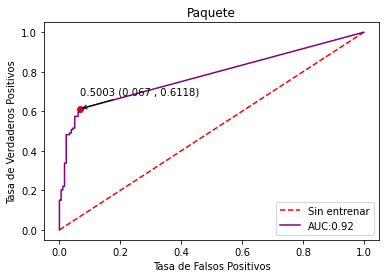

In [50]:
from sklearn.metrics import roc_curve, roc_auc_score
from numpy import argmax
# Curva ROC para etiqueta
#############################
#plt.figure(figsize=(200,200))
#############################
fpr, tpr, thres = roc_curve(true_paquete, score_paquete)
plt.plot([0, 1], [0, 1], color = 'red', linestyle='--', label='Sin entrenar')
auc = roc_auc_score(true_etiqueta, score_etiqueta)
label = 'AUC:' + str(round(auc,2))
plt.plot(fpr, tpr, label = label, color = 'purple')
# Etiquetas gráfico
plt.title('Paquete')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc = 'lower right' )
#-------------------------------------------------------------------------------
# Obtener mejor threshold
P = tpr - fpr
ix = argmax(P)
# Enontrar mejor umbral
best_thres = thres[ix]
print('Mejor umbral=%f, fpr = %f, tpr = %f' 
      % (thres[ix], fpr[ix], tpr[ix]))
# plot the roc curve for the model
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
plt.annotate(str(round(best_thres,4))+ ' (' + str(round(fpr[ix],4)) + ' , ' + str(round(tpr[ix],4)) + ')',
            xy=(fpr[ix], tpr[ix]), xycoords='data',
            xytext=(fpr[ix], tpr[ix]+0.07), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.show()

Mejor umbral=0.000000, Precision = 0.795, Recall = 1.000, F-Score=0.886


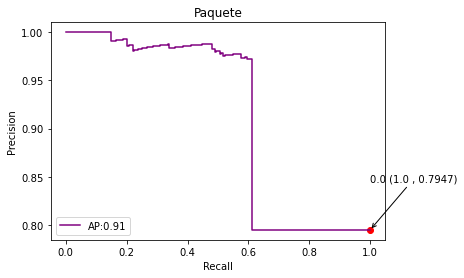

In [51]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score
from numpy import argmax
# Curva Precision-Recall para etiqueta
prec, recall, thres = precision_recall_curve(true_paquete, score_paquete)
ap = average_precision_score(true_paquete, score_paquete)
label = 'AP:' + str(round(ap,2))
# Etiquetas gráfico
display = PrecisionRecallDisplay(precision=prec, recall=recall)
display.plot(label = label, color = 'purple')
display.ax_.set_title('Paquete')
display.ax_.legend(loc = 'lower left' )
#-------------------------------------------------------------------------------
# Calcular f1-score
fscore = (2 * prec * recall) / (prec + recall)
# Enontrar índice en que se maximiza f1-score
ix = argmax(fscore)
print('Mejor umbral=%f, Precision = %.3f, Recall = %.3f, F-Score=%.3f'
 % (thres[ix], prec[ix], recall[ix], fscore[ix]))

display.ax_.scatter(recall[ix], prec[ix], marker='o', color='red', label='Best')
plt.annotate(str(round(thres[ix],4))+ ' (' + str(round(recall[ix],4)) + ' , ' + str(round(prec[ix],4)) + ')',
            xy=(recall[ix], prec[ix]), xycoords='data',
            xytext=(recall[ix], prec[ix]+0.05), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.show()
###################################################################### 

Mejor umbral=0.999975, fpr = 0.025237, tpr = 0.785586


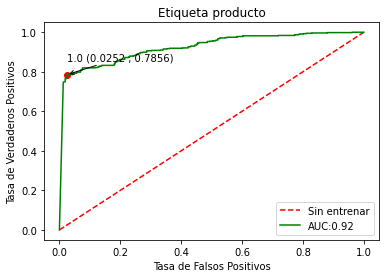

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score
from numpy import argmax
# Curva ROC para etiqueta
#############################
#plt.figure(figsize=(200,200))
#############################
fpr, tpr, thres = roc_curve(true_etiqueta , score_etiqueta)
plt.plot([0, 1], [0, 1], color = 'red', linestyle='--', label='Sin entrenar')
auc = roc_auc_score(true_etiqueta, score_etiqueta)
label = 'AUC:' + str(round(auc,2))
plt.plot(fpr, tpr, label = label, color = 'green')
# Etiquetas gráfico
plt.title('Etiqueta producto')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc = 'lower right' )
#-------------------------------------------------------------------------------
# Obtener mejor threshold
P = tpr - fpr
ix = argmax(P)
# Enontrar mejor umbral
best_thres = thres[ix]
print('Mejor umbral=%f, fpr = %f, tpr = %f' 
      % (thres[ix], fpr[ix], tpr[ix]))
# plot the roc curve for the model
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
plt.annotate(str(round(best_thres,4))+ ' (' + str(round(fpr[ix],4)) + ' , ' + str(round(tpr[ix],4)) + ')',
            xy=(fpr[ix], tpr[ix]), xycoords='data',
            xytext=(fpr[ix], tpr[ix]+0.07), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )
plt.show()

Mejor umbral=0.996403, Precision = 0.950, Recall = 0.820, F-Score=0.880


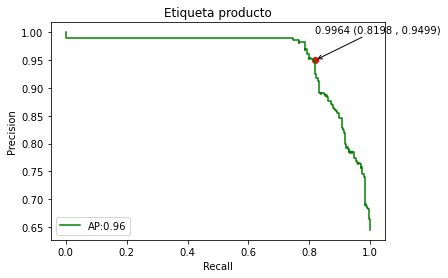

In [42]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score
from numpy import argmax
# Curva Precision-Recall para etiqueta
prec, recall, thres = precision_recall_curve(true_etiqueta, score_etiqueta)
ap = average_precision_score(true_etiqueta, score_etiqueta)
label = 'AP:' + str(round(ap,2))
# Etiquetas gráfico
display = PrecisionRecallDisplay(precision=prec, recall=recall)
display.plot(label = label, color = 'green')
display.ax_.set_title('Etiqueta producto')
display.ax_.legend(loc = 'lower left' )
#-------------------------------------------------------------------------------
# Calcular f1-score
fscore = (2 * prec * recall) / (prec + recall)
# Enontrar índice en que se maximiza f1-score
ix = argmax(fscore)
print('Mejor umbral=%f, Precision = %.3f, Recall = %.3f, F-Score=%.3f'
 % (thres[ix], prec[ix], recall[ix], fscore[ix]))
# plot the roc curve for the model
###############################
##fig = display.ax_.get_figure() 
##fig.set_figwidth(250)
##fig.set_figheight(250) 
###############################
display.ax_.scatter(recall[ix], prec[ix], marker='o', color='red', label='Best')
plt.annotate(str(round(thres[ix],4))+ ' (' + str(round(recall[ix],4)) + ' , ' + str(round(prec[ix],4)) + ')',
            xy=(recall[ix], prec[ix]), xycoords='data',
            xytext=(recall[ix], prec[ix]+0.05), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.show()
###################################################################### 

Mejor umbral=0.989849, fpr = 0.118404, tpr = 0.842105


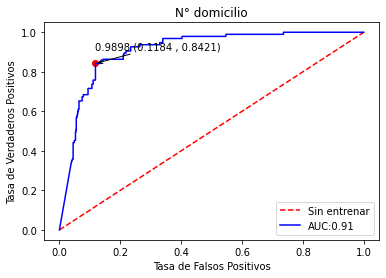

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score
# Curva ROC para n° domicilio

fpr, tpr, thres = roc_curve(true_numeracion , score_numeracion)
plt.plot([0, 1], [0, 1], color = 'red', linestyle='--', label='Sin entrenar')
auc = roc_auc_score(true_numeracion, score_numeracion)
label = 'AUC:' + str(round(auc,2))
plt.plot(fpr, tpr, label = label, color = 'blue')
# Etiquetas de los ejes
plt.title('N° domicilio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc = 'lower right' )
#-------------------------------------------------------------------------------
# Obtener mejor threshold
P = tpr - fpr
ix = argmax(P)
# Enontrar mejor umbral
best_thres = thres[ix]
print('Mejor umbral=%f, fpr = %f, tpr = %f' 
      % (thres[ix], fpr[ix], tpr[ix]))
# plot the roc curve for the model
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
plt.annotate(str(round(best_thres,4)) + ' (' + str(round(fpr[ix],4)) + ' , ' + str(round(tpr[ix],4)) + ')',
            xy=(fpr[ix], tpr[ix]), xycoords='data',
            xytext=(fpr[ix], tpr[ix]+0.07), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.show()

Mejor umbral=0.989849, Precision = 0.465, Recall = 0.842, F-Score=0.599


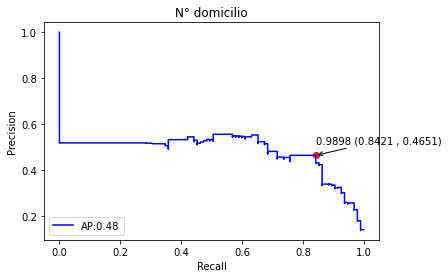

In [45]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score
# Curva Precision-Recall para numeración
prec, recall, thres = precision_recall_curve(true_numeracion, score_numeracion)
ap = average_precision_score(true_numeracion, score_numeracion)
label = 'AP:' + str(round(ap,2))
# Etiquetas gráfico
display = PrecisionRecallDisplay(precision=prec, recall=recall)
display.plot(label = label, color = 'blue')
display.ax_.set_title('N° domicilio')
display.ax_.legend(loc = 'lower left' )
#-------------------------------------------------------------------------------
# Calcular f1-score
fscore = (2 * prec * recall) / (prec + recall)
# Enontrar índice en que se maximiza f1-score
ix = argmax(fscore)
print('Mejor umbral=%f, Precision = %.3f, Recall = %.3f, F-Score=%.3f'
 % (thres[ix], prec[ix], recall[ix], fscore[ix]))
# plot the roc curve for the model
display.ax_.scatter(recall[ix], prec[ix], marker='o', color='red', label='Best') 
plt.annotate(str(round(thres[ix],4)) + ' (' + str(round(recall[ix],4)) + ' , ' + str(round(prec[ix],4)) + ')',
            xy=(recall[ix], prec[ix]), xycoords='data',
            xytext=(recall[ix], prec[ix]+0.05), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.show()
###################################################################### 

Mejor umbral=0.203457, fpr = 0.001387, tpr = 0.655629


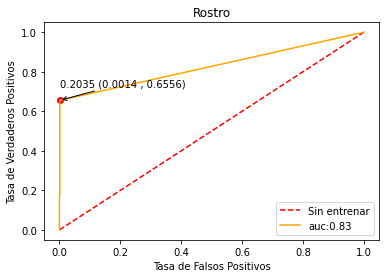

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score
# Calculamos la curva ROC para etiqueta

fpr, tpr, thres = roc_curve(true_rostro , score_rostro)
plt.plot([0, 1], [0, 1], color = 'red', linestyle='--', label='Sin entrenar')
auc = roc_auc_score(true_rostro, score_rostro)
label = 'auc:' + str(round(auc,2))
plt.plot(fpr, tpr, label = label, color = 'orange')
# Etiquetas de los ejes
plt.title('Rostro')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc = 'lower right' )
#-------------------------------------------------------------------------------
# Obtener mejor threshold
P = tpr - fpr
ix = argmax(P)
# Enontrar mejor umbral
best_thres = thres[ix]
print('Mejor umbral=%f, fpr = %f, tpr = %f' 
      % (thres[ix], fpr[ix], tpr[ix]))
# plot the roc curve for the model
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
plt.annotate(str(round(best_thres,4)) + ' (' + str(round(fpr[ix],4)) + ' , ' + str(round(tpr[ix],4)) + ')',
            xy=(fpr[ix], tpr[ix]), xycoords='data',
            xytext=(fpr[ix], tpr[ix]+0.07), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

#-------------------------------------------------------------------------------
plt.show()

Mejor umbral=0.203457, Precision = 0.990, Recall = 0.656, F-Score=0.789


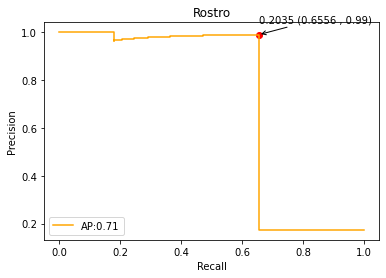

In [48]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score
# Curva Precision-Recall para rostro
prec, recall, thres = precision_recall_curve(true_rostro , score_rostro)
ap = average_precision_score(true_rostro , score_rostro)
label = 'AP:' + str(round(ap,2))
# Etiquetas gráfico
display = PrecisionRecallDisplay(precision=prec, recall=recall)
display.plot(label = label, color = 'orange')
display.ax_.set_title('Rostro')
display.ax_.legend(loc = 'lower left' )
#-------------------------------------------------------------------------------
# Calcular f1-score
fscore = (2 * prec * recall) / (prec + recall)
# Enontrar índice en que se maximiza f1-score
ix = argmax(fscore)
print('Mejor umbral=%f, Precision = %.3f, Recall = %.3f, F-Score=%.3f'
 % (thres[ix], prec[ix], recall[ix], fscore[ix]))
# plot the roc curve for the model
display.ax_.scatter(recall[ix], prec[ix], marker='o', color='red', label='Best')
plt.annotate(str(round(thres[ix],4))+ ' (' + str(round(recall[ix],4)) + ' , ' + str(round(prec[ix],4)) + ')',
            xy=(recall[ix], prec[ix]), xycoords='data',
            xytext=(recall[ix], prec[ix]+0.05), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.show()
###################################################################### 

Matriz de confusión y métricas para label paquete:
[[167  12]
 [269 424]]
accuracy: 0.6777522935779816 recall: 0.6118326118326118 precision: 0.9724770642201835 F1: 0.7511071744906999


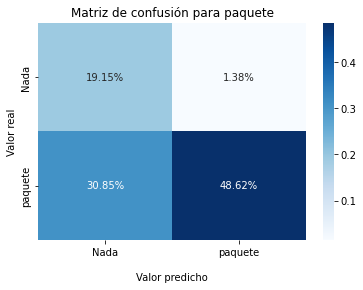

Matriz de confusión y métricas para label etiqueta:
[[258  59]
 [ 83 472]]
accuracy: 0.8371559633027523 recall: 0.8504504504504504 precision: 0.8888888888888888 F1: 0.8692449355432781


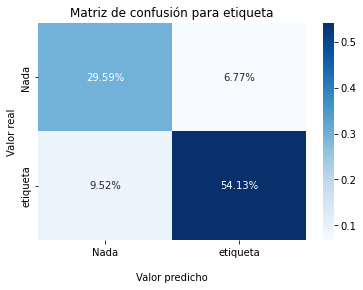

Matriz de confusión y métricas para label numeración:
[[648 129]
 [ 13  82]]
accuracy: 0.8371559633027523 recall: 0.8631578947368421 precision: 0.3886255924170616 F1: 0.5359477124183007


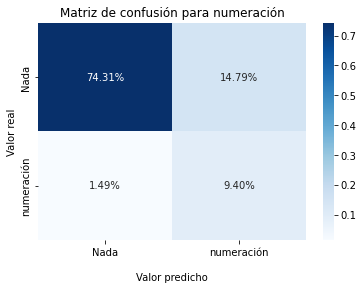

Matriz de confusión y métricas para label rostro:
[[720   1]
 [ 68  83]]
accuracy: 0.9208715596330275 recall: 0.5496688741721855 precision: 0.9880952380952381 F1: 0.7063829787234044


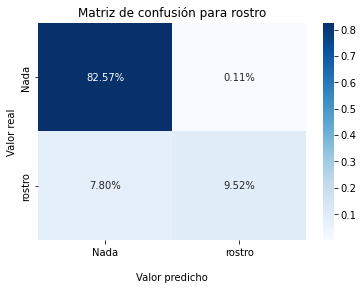

In [52]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true = np.array(y_true)
y_pred = np.array(y_pred)

labels = ["paquete", "etiqueta", "numeración", "rostro"]

conf_mat_dict={}

for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)


for label, matrix in conf_mat_dict.items():
    print("Matriz de confusión y métricas para label {}:".format(label))
    print(matrix)
    accuracy = (matrix[0][0]+matrix[1][1])/(matrix[0][0] + matrix[0][1] + matrix[1][0]+matrix[1][1])
    recall = matrix[1][1]/(matrix[1][1]+matrix[1][0])
    precision = matrix[1][1]/(matrix[1][1]+matrix[0][1])
    F1 = 2*recall*precision/(recall + precision)
    print('accuracy:', accuracy, 'recall:', recall, 'precision:', precision, 'F1:', F1)
    ax = sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%', cmap='Blues')

    ax.set_title("Matriz de confusión para {}".format(label));
    ax.set_xlabel('\nValor predicho')
    ax.set_ylabel('Valor real');

    ax.xaxis.set_ticklabels(['Nada', label])
    ax.yaxis.set_ticklabels(['Nada', label])

    plt.show()